In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.patches as patches
import matplotlib.colors
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
from helpers import sel_season_indx

In [4]:
data_dir = "../precip_data"
#data_dir = '/Volumes/My Passport for Mac/cnn/data_update/with_precip/precip_data'

In [5]:
reference = 'mpc'
score = 'bs'
season = 'JAS'

In [6]:
forecast = 'logit' #'logit', 'logit_base' 'dim', 'dim_base', 'cnn', 'hybrid', 'hres', 'ecmwf', 'ecmwf_pp', 'emos'

In [7]:
if forecast in ['logit_base', 'dim_base']:
    feature_set = 'v1+time' #'v1+time'
else:
    feature_set = 'v2+time'

In [8]:
lsm = np.loadtxt(data_dir  + "/lsm.txt")
data_models = data_dir + '/results/full_models/'
data_emos = data_dir + '/results/prev_results_emos/'

In [12]:
if forecast in ['logit', 'logit_base', 'ecmwf_pp']:
    if score != 'bs':
        raise ValueError('score must be equal to bs')

In [9]:
model_ref = np.zeros((19, 61))
model_fct = np.zeros((19, 61))
for fold in range(9):
    score_map = xr.open_dataset(data_models + reference + '_'+score+'_' + season + '_' + str(fold) + '.nc')
    model_ref = model_ref +score_map['var'].values
    if forecast in ['logit', 'logit_base', 'dim', 'dim_base', 'cnn', 'hybrid']:
        score_map2 = xr.open_dataset(data_models + forecast + '_'+score+ '_' + season + '_' + str(fold) +'.nc')
        #score_map2 = xr.open_dataset(data_dir + forecast + '_' + score + '_' + str(feature_set) +  '_' + season + '_' + str(fold) +'.nc')
        model_fct = model_fct +score_map2['var'].values
    elif forecast == 'emos':
        X = np.loadtxt(data_emos + 'emos_'+score+'_'+str(fold)+'.txt')
        year_dim = 365
        if fold == 1 or fold == 5:
            year_dim = 366
        ix0, ix1 = sel_season_indx(season, year_dim)
        X2 = np.mean(X[:, ix0:ix1], axis = 1)
        
        valid_mask = lsm != 0
        # Initialize `emos_map` with NaN values
        emos_map = np.full_like(lsm, np.nan, dtype=np.float64)
        # Assign values from X2 to `emos_map` using the mask
        emos_map[valid_mask] = X2[:np.count_nonzero(valid_mask)]
        model_fct = model_fct + emos_map
    else:
        score_map2 = xr.open_dataset(data_models + forecast + '_'+score+ '_' + season + '_' + str(fold) +'.nc')
        model_fct = model_fct +score_map2['var'].values
model_ref_mean = model_ref / 9
model_fct_mean = model_fct / 9

In [10]:
top = plt.get_cmap('Reds_r', 128)
bottom = plt.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
cmap = ListedColormap(newcolors, name='RedBlue')

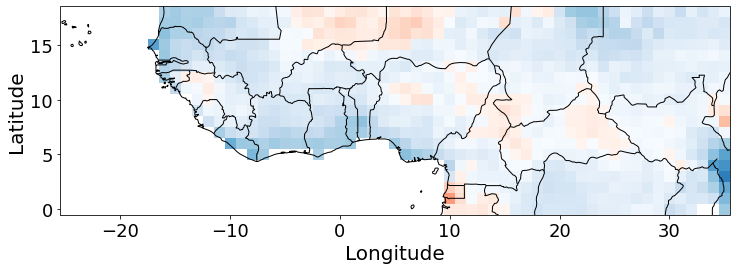

In [11]:
lat = np.arange(19)
lon = np.arange(-25, 35.5, 1)
#lons, lats = np.meshgrid(lons, lats)
fct = model_fct_mean
perfect = np.zeros((19, 61))
reference = model_ref_mean


map_val = (fct - reference) / (perfect - reference)
#map_val = np.where(np.isnan(map_val), 0, map_val)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 5))
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Use ax.pcolormesh and specify the transform
mesh = ax.pcolormesh(lon, lat,map_val, transform=ccrs.PlateCarree(), cmap=cmap, vmax = 0.4, vmin = -0.4, shading = 'auto') 
                 
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

#cbar = fig.colorbar(cf, orientation='vertical',  fraction=0.015, pad=0.02)
#cbar.ax.tick_params(labelsize=18)
x = ax.set_xlabel('Longitude',fontsize = 20)
x = ax.set_ylabel('Latitude', fontsize = 20)
x = ax.set_xticks([-20, -10 , 0, 10, 20, 30])
x = ax.set_yticks([ 0, 5, 10, 15])
x = ax.tick_params(axis='y', labelsize=18)
x = ax.tick_params(axis='x', labelsize=18)